In [1]:
# !pip install gnss_lib_py

In [2]:
import numpy as np
import gnss_lib_py as glp
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import pandas as pd
import xarray as xarr

https://drive.google.com/drive/folders/17vNrS_-Kq0msv2r9VHDkry3aEAxUcdAS

### Pseudorange computation

In [8]:
def compute_pseudoranges(raw_data):
    nanosecs_in_week = 604800e9
    speed_of_light = 299792458
    week_no = np.floor(-raw_data['FullBiasNanos']/nanosecs_in_week)
    corrected_rx_time = raw_data['TimeNanos'] + raw_data['TimeOffsetNanos']
    adjusted_rx_bias = raw_data['FullBiasNanos'] + raw_data['BiasNanos']
    rx_time_gps_frame = corrected_rx_time - adjusted_rx_bias
    rx_time_week_frame = rx_time_gps_frame - week_no * nanosecs_in_week
    rho_nanosecs = rx_time_week_frame - raw_data['ReceivedSvTimeNanos']
    rho_m = rho_nanosecs * speed_of_light/1e9
    return rho_m

In [9]:
rover_path = './Oval/RoundLoop1_gnss_log_2024_11_17_16_52_31.txt'
base_path = './Oval/RoundLoop1_BaseStation_gnss_log_2024_11_17_16_52_30.txt'

In [10]:
rover_data = glp.AndroidRawGnss(input_path=rover_path,
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)
rover_data['FullBiasNanos'] = rover_data['FullBiasNanos'] - 604800e9
rover_data['TimeNanos'] = rover_data['TimeNanos'] - 604800e9
offset_ms_rover = -150
offset_ms_base = -150

base_data = glp.AndroidRawGnss(input_path=base_path,
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)


offset_rover_data = rover_data.copy()
offset_base_data = base_data.copy()
offset_rover_data["gps_millis"] = rover_data["gps_millis"] + offset_ms_rover
offset_base_data["gps_millis"] = base_data["gps_millis"] + offset_ms_base

sv_time_uncertainty removed 1
sv_time_uncertainty removed 1


In [11]:
rover_data_gps_only = offset_rover_data.where('gnss_id', ('gps'), 'eq')
base_data_gps_only = offset_base_data.where('gnss_id', ('gps'), 'eq')

In [12]:
rover_rho = compute_pseudoranges(rover_data_gps_only)

In [13]:
rover_rho

array([23901193.24822395, 23555168.29631347, 20822048.59571012,
       20566333.12384758, 22491769.37206989, 20352576.6044067 ,
       21936095.3571856 , 24547410.28148093, 20781426.11806621,
       21256784.83407491, 23901298.4753767 , 23555721.11360602,
       20822145.1288816 , 20566496.51073718, 22491657.84927551,
       20352430.00589474, 21935523.6529682 , 24547752.94426042,
       20781458.79544413, 21257125.09851474, 23901409.99817108,
       23556256.84272847, 20822242.86122291, 20566662.89555138,
       22491536.13353756, 20352267.5183825 , 21934954.94667537,
       24548081.21700193, 20781495.37012401, 21257475.55589815,
       23901507.73051238, 23556813.85711543, 20822338.49501701,
       20566824.48368623, 22491424.01115827, 20352107.12941748,
       21934386.83996746, 24548414.88600769, 20781524.44999243,
       21257814.02158323, 23901610.25953302, 23557329.20035074,
       20822451.51677367, 20566994.16621746, 22491319.08379797,
       20351961.13049043, 21933822.33076

In [14]:
def interpolate_base_values(rover_data_gps_millis, base_data_for_sat):
    '''
    rover_data_gps_millis: This is the GPS millis time for a single measurement in the rover data
    base_data_for_sat: This are all the measurements in the base data for a single satellite (i.e. the
                        sv_id and gnss_id have already been matched).

    Returns:
    Interpolated data: All the data columns in the base data interpolated to get values for the exact gps millis used
                       in the rover data.
    success: If interpolation was successful. If not, flag to indicate that we should throw out that data point.
    '''
    GPS_MILLIS_COL = -3
    upper_index = np.searchsorted(base_data_for_sat['gps_millis'], rover_data_gps_millis)
    base_data_array_ver = base_data_for_sat.array
    row_lower = base_data_array_ver[:, upper_index-1]
    row_higher = base_data_array_ver[:, upper_index]
    interpolated_data_arr = row_lower + (rover_data_gps_millis - row_lower[GPS_MILLIS_COL])/(row_higher[GPS_MILLIS_COL] - row_lower[GPS_MILLIS_COL]) * (row_higher - row_lower)
    interpolated_data_pd = pd.DataFrame(columns = base_data_for_sat.rows)
    interpolated_data_pd.loc[0] = interpolated_data_arr
    interpolated_data = glp.NavData()
    interpolated_data.from_pandas_df(interpolated_data_pd)
    # There might be more edge cases
    if (upper_index - 1) < 0:
        success = False
    else:
        success = True

    return interpolated_data, success

In [15]:
def compute_and_match_pr(rover_data, base_data):
    base_rho = []
    base_matched_data = []
    # time_tolerance = 5000
    for i in range(len(rover_data)):
        sv_id = rover_data['sv_id']
        gnss_id = rover_data['gnss_id']
        gps_millis = rover_data['gps_millis']
        print(f'Rover data uses sv id of {sv_id[i]}, gnss id of {gnss_id[i]}, millis of {gps_millis[i]}')
        a = base_data.where("sv_id", sv_id[i], "eq")
        b = a.where("gnss_id", gnss_id[i], "eq")
        # c = b.where("gps_millis", gps_millis[i]-time_tolerance, "geq").where("gps_millis", gps_millis[i]+time_tolerance, "leq")
        c, success = interpolate_base_values(gps_millis[i], b)
        
        if not success:
            print('WARNING: UNSUCUESSFUL INTERPOLATION')
        rho_vals = compute_pseudoranges(c)
        # try: 
        #     if len(rho_vals) > 0:
        #         rho_m = rho_vals[0]
        #         c_val = c[:, 0]
        #     else:
        #         rho_m = np.nan
        #         c_val = np.nan
        # except:
        #     rho_m = rho_vals
        #     c_val = c.array[:, 0]
        # base_rho.append(rho_m)
        base_rho.append(rho_vals)
        # base_matched_data.append(c_val)
        base_matched_data.append(c.array.squeeze())
    return base_matched_data, base_rho
matched_base_data, base_rho = compute_and_match_pr(rover_data_gps_only, base_data_gps_only)
base_rho = np.array(base_rho)

Rover data uses sv id of 2, gnss id of gps, millis of 1415926367289.0
Rover data uses sv id of 7, gnss id of gps, millis of 1415926367289.0
Rover data uses sv id of 13, gnss id of gps, millis of 1415926367289.0
Rover data uses sv id of 14, gnss id of gps, millis of 1415926367289.0
Rover data uses sv id of 15, gnss id of gps, millis of 1415926367289.0
Rover data uses sv id of 17, gnss id of gps, millis of 1415926367289.0
Rover data uses sv id of 19, gnss id of gps, millis of 1415926367289.0
Rover data uses sv id of 21, gnss id of gps, millis of 1415926367289.0
Rover data uses sv id of 22, gnss id of gps, millis of 1415926367289.0
Rover data uses sv id of 30, gnss id of gps, millis of 1415926367289.0
Rover data uses sv id of 2, gnss id of gps, millis of 1415926368289.0
Rover data uses sv id of 7, gnss id of gps, millis of 1415926368289.0
Rover data uses sv id of 13, gnss id of gps, millis of 1415926368289.0
Rover data uses sv id of 14, gnss id of gps, millis of 1415926368289.0
Rover data

### Load SLAC Data instead

In [16]:
# Load the .npz file
loaded = np.load("test_slac/extracted_data.npz")
slac_time = loaded['time']
slac_sv = loaded['sv']
slac_C1 = loaded['C1']
slac_P1 = loaded['P1']
slac_true_pos = loaded['true_pos']


In [267]:
# Convert to datetime
datetime_obj = [datetime.utcfromtimestamp(ts.astype('datetime64[s]').astype(int)) for ts in slac_time]
slac_millis_offset = -18150.0
slac_gps_millis = np.array([glp.datetime_to_gps_millis(dt_now) for dt_now in datetime_obj]) + slac_millis_offset
print(slac_gps_millis)

[1.41592320e+12 1.41592321e+12 1.41592323e+12 ... 1.41600955e+12
 1.41600957e+12 1.41600958e+12]


/home/gigavoltflash/miniconda3/lib/python3.9/site-packages/gnss_lib_py/utils/time_conversions.py:586: RuntimeWarning:

No time zone info found in datetime, assuming UTC



In [268]:
def interpolate_slac_values(rover_data_gps_millis, slac_time, slac_C1):
    # assumes that slac time is in millis too
    upper_index = np.searchsorted(slac_time, rover_data_gps_millis)
    t0 = slac_time[upper_index-1]
    t1 = slac_time[upper_index]
    pr_t0 = slac_C1[upper_index-1]
    pr_t1 = slac_C1[upper_index]
    pr = pr_t0 + (rover_data_gps_millis - t0)/(t1 - t0) * (pr_t1 - pr_t0)
    return pr

# assumes that we're only using GPS for now
def compute_and_match_pr_slac(rover_data, slac_time, slac_C1, slac_sv):
    pr = np.zeros(len(rover_data))
    for i in range(len(rover_data)):
        sv_id = rover_data['sv_id']
        gnss_id = rover_data['gnss_id']
        gps_millis = rover_data['gps_millis']
        print('G{:02}'.format(sv_id[i]))
        print(f'Rover data uses sv id of {sv_id[i]}, gnss id of {gnss_id[i]}, millis of {gps_millis[i]}')
        sv_index = np.where(slac_sv == 'G{:02}'.format(sv_id[i]))[0][0]
        pr[i] = interpolate_slac_values(gps_millis[i], slac_time, slac_C1[:, sv_index])
    return pr
slac_pr = compute_and_match_pr_slac(rover_data_gps_only, slac_gps_millis, slac_C1, slac_sv)

G02
Rover data uses sv id of 2, gnss id of gps, millis of 1415926367289.0
G07
Rover data uses sv id of 7, gnss id of gps, millis of 1415926367289.0
G13
Rover data uses sv id of 13, gnss id of gps, millis of 1415926367289.0
G14
Rover data uses sv id of 14, gnss id of gps, millis of 1415926367289.0
G15
Rover data uses sv id of 15, gnss id of gps, millis of 1415926367289.0
G17
Rover data uses sv id of 17, gnss id of gps, millis of 1415926367289.0
G19
Rover data uses sv id of 19, gnss id of gps, millis of 1415926367289.0
G21
Rover data uses sv id of 21, gnss id of gps, millis of 1415926367289.0
G22
Rover data uses sv id of 22, gnss id of gps, millis of 1415926367289.0
G30
Rover data uses sv id of 30, gnss id of gps, millis of 1415926367289.0
G02
Rover data uses sv id of 2, gnss id of gps, millis of 1415926368289.0
G07
Rover data uses sv id of 7, gnss id of gps, millis of 1415926368289.0
G13
Rover data uses sv id of 13, gnss id of gps, millis of 1415926368289.0
G14
Rover data uses sv id of 

### Verifying that the rover is matched well to base measurements

(20000000.0, 25000000.0)

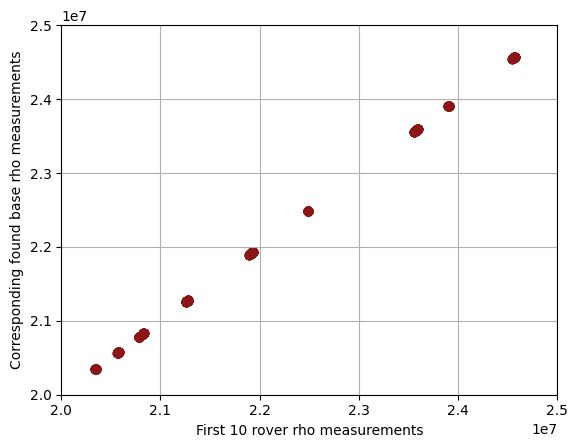

In [269]:
plt.scatter(rover_rho, base_rho)
plt.grid()
plt.xlabel('First 10 rover rho measurements')
plt.ylabel('Corresponding found base rho measurements')
plt.xlim(2e7, 2.5e7)
plt.ylim(2e7, 2.5e7)

(20000000.0, 25000000.0)

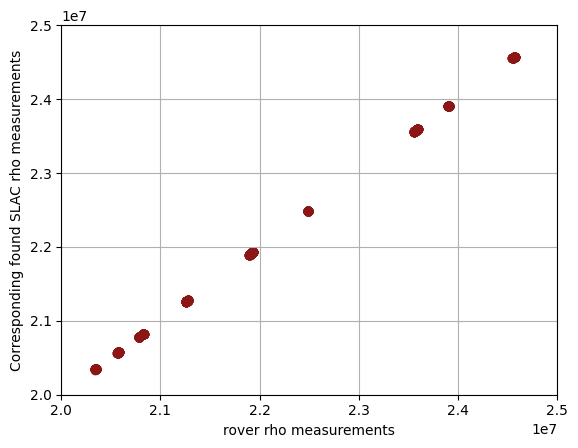

In [270]:
plt.scatter(rover_rho, slac_pr)
plt.grid()
plt.xlabel('rover rho measurements')
plt.ylabel('Corresponding found SLAC rho measurements')
plt.xlim(2e7, 2.5e7)
plt.ylim(2e7, 2.5e7)

In [271]:
timestamps = rover_data_gps_only['gps_millis']
base_timestamps = base_data_gps_only['gps_millis']
satellites = rover_data_gps_only['sv_id']
print(f'number of unique timesteps {len(np.unique(timestamps))}')

number of unique timesteps 75


### Calculate true ranges

In [239]:
BASE_STATION_LOCATION_1 = np.array([37.429711,-122.169381,25]).reshape(3, 1)
BASE_STATION_LOCATION_2 = np.array([37.4290631,-122.1723136,25]).reshape(3, 1) # multipath test

DURAND = np.array([[37.426906], [-122.173278], [21.010]]) 

In [75]:
gps_millis_column = -3
sv_id_column = 11
gnss_id_column = -13

In [76]:
matched_base_data_clean = np.zeros((len(matched_base_data),len(matched_base_data[0])))
for i in range(len(matched_base_data)):
    matched_base_data_clean[i, :] = matched_base_data[i]
    matched_base_data_clean[i, gnss_id_column] = 100.0

In [30]:
## Load the RinexNav data for that day
rinex_nav_paths = glp.load_ephemeris(
    "rinex_nav",
    np.array(np.nanmin(matched_base_data_clean[:, gps_millis_column]),np.nanmax(matched_base_data_clean[:, gps_millis_column])),
    verbose=True,
)
rinex_nav = glp.RinexNav(rinex_nav_paths, verbose=True)

ephemeris dates needed: [datetime.date(2024, 11, 17), datetime.date(2024, 11, 18)]
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243220000_01D_MN.rnx
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243230000_01D_MN.rnx
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243220000_01D_MN.rnx
using previously downloaded file:
 /home/gigavoltflash/stanford_classes/AA_272/dgnss_aa272/data/ephemeris/rinex/nav/BRDM00DLR_S_20243230000_01D_MN.rnx


In [31]:
GNSS_ID_FLOAT = 100.0
def find_sv_pos(rinex, gnss_data_array):
    """ finding sv position with ephemeris data FOR DURAND receiver"""
    sv_id = gnss_data_array[:, sv_id_column]
    gps_millis = gnss_data_array[:, gps_millis_column]
    n = len(sv_id)
    position_info = np.zeros((n, 3))
    bias_info = np.zeros(n)
    for i in range(n):
        print(i)
        sv_at_millis = glp.find_sv_states(gps_millis[i], rinex)
        cropped_sv_at_millis = sv_at_millis.where('sv_id', sv_id[i], 'eq')
        gnss_id_at_millis = cropped_sv_at_millis.where('gnss_id', ('gps'), 'eq')
        # TODO: JANK PLS FIX AND DO SOMETHING SMARTER
        position_info[i, 0] = np.mean(gnss_id_at_millis['x_sv_m'])
        position_info[i, 1] = np.mean(gnss_id_at_millis['y_sv_m'])
        position_info[i, 2] = np.mean(gnss_id_at_millis['z_sv_m'])
        bias_info[i] = np.mean(gnss_id_at_millis['b_sv_m'])
    return position_info, bias_info

# FOR DURAND DATA
# def get_measured_pseudorange(df,sv_id):
#     """ get measured pseudorange of specific sv for durand receiver"""
#     filtered_df = df[df.iloc[:,4] == str(sv_id)]
#     return filtered_df.iloc[:,14]

def distance_to_groundtruth(sv_pos, ground_truth):
    """ calculate ground truth distance from SV to Durand receiver"""
    gt_ecef = glp.geodetic_to_ecef(ground_truth)
    distance = np.linalg.norm(sv_pos[:, :, None] - gt_ecef[None, :, :], axis=1)
    return distance

def correction(true_range, base_pseudorange, rover_pseudorange):
    """ true_range: ground truth distance from distance_to_groundtruth function
    base_pseudorange: pseudorange for base station
    pseudorange: pseudorange for phone """
    e = true_range - base_pseudorange
    adjusted_pseudorange = rover_pseudorange + e
    return adjusted_pseudorange



# def get_pseudorange(raw_data, sv_id):
#     """ get measure pseudorange of the rover with specified sv_id"""
#     cropped_data = raw_data.where("sv_id", sv_id, "eq")
#     pseudorange = compute_pseudoranges(cropped_data)
#     return pseudorange

In [32]:
sv_pos, sv_bias = find_sv_pos(rinex_nav, matched_base_data_clean)
# sv_pos_base_data_gps_only, sv_bias_base_data_gps_only = find_sv_pos(rinex_nav, base_data_gps_only.array.T)
# sv_pos = find_sv_pos(rover_ephemeris, 6)
# true_ranges = distance_to_groundtruth()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [272]:
rover_rho_corrected = rover_rho + sv_bias
base_rho_corrected = base_rho + sv_bias
slac_pr_corrected = slac_pr + sv_bias

### Actual dGNSS shit

In [273]:
slac_true_pos[:, None]

array([[-2703115.266],
       [-4291768.344],
       [ 3854247.955]])

In [274]:
np.linalg.norm(sv_pos.T - slac_true_pos[:, None], axis=0)

array([23810750.99232981, 23550998.42287404, 21025917.24448961,
       20729934.3540754 , 22558435.08906547, 20518682.75978752,
       22103463.38467498, 24579660.54727209, 20757205.04970451,
       21174119.70987151, 23810849.56494675, 23551534.53932662,
       21026011.53478114, 20730097.15065339, 22558317.09617686,
       20518526.8838809 , 22102893.25714629, 24579989.70115778,
       20757231.44599317, 21174457.92094229, 23810948.24615609,
       23552070.70812796, 21026105.95440624, 20730259.99430593,
       22558199.23220493, 20518371.12381011, 22102323.19534753,
       24580318.95686631, 20757257.8911868 , 21174796.21239883,
       23811047.03595764, 23552606.92927181, 21026200.5033606 ,
       20730422.8850283 , 22558081.49715169, 20518215.47957662,
       22101753.1992936 , 24580648.31438745, 20757284.38527885,
       21175134.58423935, 23811145.93435124, 23553143.20275194,
       21026295.18163994, 20730585.82281575, 22557963.89101913,
       20518059.95118184, 22101183.26899

In [275]:
BASE_STATION_LOCATION_1

array([[  37.429711],
       [-122.169381],
       [  25.      ]])

In [276]:
true_range = distance_to_groundtruth(sv_pos, BASE_STATION_LOCATION_1).flatten()
corrected_pseudorange = correction(true_range, base_rho_corrected, rover_rho_corrected)
# SLAC version
true_range_slac = np.linalg.norm(sv_pos.T - slac_true_pos[:, None], axis=0)
corrected_pseudorange_slac = correction(true_range_slac, slac_pr_corrected, rover_rho_corrected)

Text(0.5, 1.0, 'Phone base station')

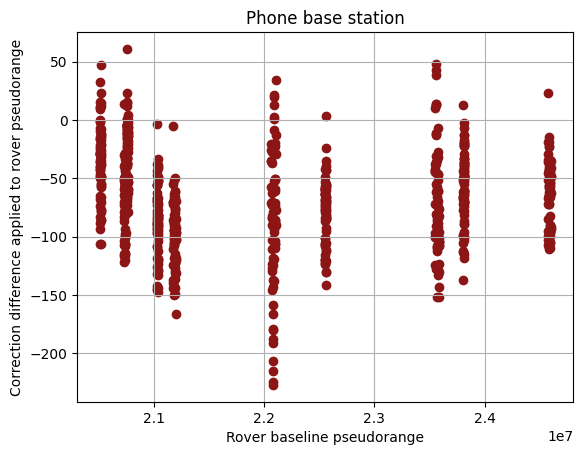

In [277]:
plt.scatter(rover_rho_corrected, corrected_pseudorange - rover_rho_corrected)
plt.xlabel('Rover baseline pseudorange')
plt.ylabel('Correction difference applied to rover pseudorange')
plt.grid()
plt.title('Phone base station')

Text(0.5, 1.0, 'SLAC base station')

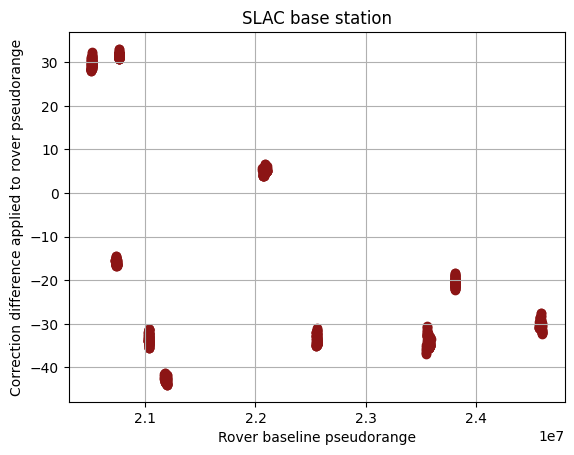

In [278]:
plt.scatter(rover_rho_corrected, corrected_pseudorange_slac - rover_rho_corrected)
plt.xlabel('Rover baseline pseudorange')
plt.ylabel('Correction difference applied to rover pseudorange')
plt.grid()
plt.title('SLAC base station')

### Newton Raphson to solve for position

In [279]:
def newton_raphson(x0, bu_0, max_iterations, dataset):
    """
    Function description: perform newton raphson to compute position of observer based on available satellite
    data, stop function when we have updates in delta_x, delta_bu that are less than a centimeter,
    or hit maximum number of iterations

    Inputs:
    1) x_0: initial guess for position
    2) bu_0: initial guess for clock bias
    3) max_iterations: maximum number of iterations until covergence
    4) dataset_name: name of file to read in

    return: 
    1) optimized position
    2) optimized clock bias
    3) number of iterations until covergence
    """
    x_est = x0
    b_est = bu_0


    for i in range(max_iterations):

        # Get Geometry Matrix and deltas for rho
        geometry_matrix = []
        delta_rho = []
        for index, sat in dataset.iterrows():
            geometry_matrix.append(get_geometry_row(x_est, sat['x_sv_m'], sat['y_sv_m'], sat['z_sv_m']))
            delta_rho.append(sat['corr_pr_m'] - get_theoretical_pseudoranges(x_est, b_est, sat['x_sv_m'], sat['y_sv_m'], sat['z_sv_m']))

        # Convert into matricies to make it easier to use numpy functions
        geometry_matrix = np.array(geometry_matrix)
        delta_rho = np.array(delta_rho)

        # Update the deltas
        delta_x, delta_bu = newton_raphson_step(geometry_matrix, delta_rho)
        x_est = np.add(x_est, delta_x)
        b_est = b_est + delta_bu
    
        if True: #i%10 == 0:
            print("round: ",i+1)
            print("x_est: ", x_est)
            print("b_est: ", b_est)

        if delta_x[0] < 0.01 and delta_x[1] < 0.01 and delta_x[2] < 0.01 and delta_bu < 0.01:
            break
    
    
    print("round: ",i+1)
    print("FINAL - x_est: ", x_est)
    print("FINAL - b_est: ", b_est)
    return x_est


def get_geometry_row(x_est, x_sv_m, y_sv_m, z_sv_m):
    """
    Function description: Compute each row for the geometry matrix given a satellite position and
    current guess for position estimate

    Inputs:
    1) x_est: current guess for current position estimate 
    2) x_sv_m: a set for satellite position x
    3) y_sv_m: a set for satellite position y
    4) z_sv_m: a set for satellite position z


    return: 
    1) Geometry Matrix G (first 3 columns unit vector)
    """

    x = x_sv_m - x_est[0]
    y = y_sv_m - x_est[1]
    z = z_sv_m - x_est[2]

    magnitude = np.sqrt((x)**2 + (y)**2 + (z)**2)

    return ([-x/magnitude, -y/magnitude, -z/magnitude, 1])



def get_theoretical_pseudoranges(x_est, b_est, x_sv_m, y_sv_m, z_sv_m):
    """
    Function description: Compute each row for the geometry matrix given a satellite position and
    current guess for position estimate

    Inputs:
    1) x_est: current position estimate 
    2) b_est: current clock bias estimate 
    3) x_sv_m: a set for satellite position x
    4) y_sv_m: a set for satellite position y
    5) z_sv_m: a set for satellite position z

    return: 
    1) Theoretical pseudorange measurement vector
    """


    x = x_sv_m - x_est[0]
    y = y_sv_m - x_est[1]
    z = z_sv_m - x_est[2]

    magnitude = np.sqrt((x)**2 + (y)**2 + (z)**2)
    b_k = 0 # assume its zero for all satellites, already corrrected for in data

    return magnitude + b_est - b_k

def newton_raphson_step(G,delta_rho):
    """
    Function description: Take one step of newton-raphson optimization, compute update of 
    delta_x and delta_bu

    Input:
    1) G: geometry matrix
    2) delta_rho: difference of theoretical and measured pseudoranges 

    return:
    1) delta_x
    2) delta_bu
    """
    G_t = G.transpose()
    deltas = np.matmul(np.matmul(np.linalg.inv(np.matmul(G_t, G)),G_t),delta_rho)

    delta_x = deltas[0:3]
    delta_bu = deltas[3]

    return delta_x, delta_bu

In [280]:
def generate_lat_lon(millis, sv_pos, pr_vals, name):
    unique_millis = np.unique(millis)
    pos_ls = []
    # batch pr with same millis
    for i in range(len(unique_millis)):
        mask = millis == unique_millis[i]
        pr = pr_vals[mask]
        x = sv_pos[mask, 0]
        y = sv_pos[mask, 1]
        z = sv_pos[mask, 2]

        # Create DataFrame using the arrays
        df = pd.DataFrame({
            'x_sv_m': x,
            'y_sv_m': y,
            'z_sv_m': z,
            'corr_pr_m': pr
        })

        df_cleaned = df.dropna()
        pos = newton_raphson([0,0,0],0,30,df_cleaned)

        print("Lat/Long Version: ",glp.ecef_to_geodetic(pos))

        pos_ls.append(glp.ecef_to_geodetic(pos))

    pos_array = np.array(pos_ls)
    final_data = glp.NavData()
    final_data[f'lat_{name}_deg'] = pos_array[:,:,0]
    final_data[f'lon_{name}_deg'] = pos_array[:,:,1]
    return final_data

In [281]:
dgnss = generate_lat_lon(timestamps, sv_pos, corrected_pseudorange, 'dgnss')
rover = generate_lat_lon(timestamps, sv_pos, rover_rho_corrected, 'rover')
base = generate_lat_lon(timestamps, sv_pos, base_rho_corrected, 'base')
slac = generate_lat_lon(timestamps, sv_pos, slac_pr_corrected, 'slac')
dgnss_slac = generate_lat_lon(timestamps, sv_pos, corrected_pseudorange_slac, 'dgnss_slac')
# base_gps_only = generate_lat_lon(base_timestamps, sv_pos_base_data_gps_only, base_data_gps_only['raw_pr_m'])

round:  1
x_est:  [-3190251.31383807 -5150262.47820829  4662429.50866617]
b_est:  1319726.909385277
round:  2
x_est:  [-2713026.28314282 -4320264.1585328   3883488.83775493]
b_est:  45363.07084091054
round:  3
x_est:  [-2700013.24814327 -4292671.95987435  3855425.64188104]
b_est:  67.8568855227204
round:  4
x_est:  [-2700000.91527598 -4292640.69946591  3855392.07511939]
b_est:  17.228438449774643
round:  5
x_est:  [-2700000.91526298 -4292640.69942699  3855392.0750757 ]
b_est:  17.228373461157243
round:  5
FINAL - x_est:  [-2700000.91526298 -4292640.69942699  3855392.0750757 ]
FINAL - b_est:  17.228373461157243
Lat/Long Version:  [[  37.42974183 -122.16922257   28.32538739]]
round:  1
x_est:  [-3190237.56851094 -5150238.14215363  4662397.80959752]
b_est:  1319630.6855757888
round:  2
x_est:  [-2713033.27592944 -4320269.26640568  3883497.2852173 ]
b_est:  45309.44578724634
round:  3
x_est:  [-2700022.55151407 -4292680.49374311  3855438.92189252]
b_est:  20.187115177861415
round:  4
x_est

In [283]:
ls = []
ls.append(dgnss)
ls.append(base)
ls.append(rover)

a = []
# a.append(base)
a.append(rover)
# a.append(dgnss)
a.append(slac)
a.append(dgnss_slac)
glp.plot_map(*a)
# glp.plot_map(rover)
# glp.plot_map(base_gps_only)

